In [1]:
import datetime
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
data = pandas.read_csv('samples/features.csv', index_col='match_id')
data_size = len(data)

### Проверка выборки на наличие пропусков

In [3]:
pass_result = reversed(sorted(map(lambda nc: (1 - nc[0] / data_size, nc[1]),
                                  filter(lambda nc: nc[0] < data_size,
                                         [(data[col_name].count(), col_name) for col_name in data.columns]))))
print('\n'.join(map(lambda nc: nc[1] + ': ' + str(round(nc[0], 3)), pass_result)))

first_blood_player2: 0.452
radiant_flying_courier_time: 0.283
dire_flying_courier_time: 0.268
first_blood_time: 0.201
first_blood_team: 0.201
first_blood_player1: 0.201
dire_bottle_time: 0.166
radiant_bottle_time: 0.161
radiant_first_ward_time: 0.019
dire_first_ward_time: 0.019
radiant_courier_time: 0.007
dire_courier_time: 0.007


### Объяснение некоторых пропусков

* **first\_blood_\*** - Если за первые 5 минут не произошло событие "первая кровь", то поля, начинающиеся с этого префикса, не заполнены. Также, первое убийство чаще происходит одним игроком, поэтому поле first_blood_player1 заполнено больше, чем поле first_blood_player2;
* **radiant_courier_time, dire_courier_time** - Если команда не получила предмет "courier", то соответствующие команде поле не заполнено;
* **dire_first_ward_time** - Если команда за первые 5 минут не установила "наблюдателя", то данное поле не заполнено.

### Удаление признаков, связанных с итогами матча. Разделение данных на признаки и целевую переменную

In [4]:
X = data.drop(
    ['duration', 'tower_status_radiant', 'tower_status_dire',
     'barracks_status_radiant', 'barracks_status_dire', 'radiant_win'], axis=1)
y = data.radiant_win

Столбец, содержащий целевую переменную - radiant_win

### Замена пропусков на нули

In [5]:
X = X.fillna(0)

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=241)

### Функция для отрисовки графиков

In [7]:
def plot_chart(x, y, x_label, y_label):
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Подход 1: градиентный бустинг "в лоб"

In [8]:
def start_gradient_boosting(x_in):
    est_nums = [10, 20, 30, 50, 100, 250]
    means = []

    for estimators_number in est_nums:
        print('\nestimators_number =', estimators_number)

        clf = GradientBoostingClassifier(n_estimators=estimators_number, random_state=241)

        start_time = datetime.datetime.now()
        score = cross_val_score(clf, x_in, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        finish_time = datetime.datetime.now() - start_time

        mean = np.mean(score)
        means.append(mean)

        print('score =', score)
        print('mean =', mean)
        print('time =', finish_time)

    return est_nums, means

In [9]:
nums, scores = start_gradient_boosting(X)


estimators_number = 10
score = [ 0.66943496  0.65627754  0.66390454  0.66281223  0.66950933]
mean = 0.664387720635
time = 0:00:11.249927

estimators_number = 20
score = [ 0.68939011  0.67567277  0.68201026  0.67977584  0.68741889]
mean = 0.682853573534
time = 0:00:19.805838

estimators_number = 30
score = [ 0.69641668  0.68365441  0.68731862  0.68728458  0.69280674]
mean = 0.689496206059
time = 0:00:27.889636

estimators_number = 50
score = [ 0.70382382  0.69325852  0.69452532  0.69565719  0.7000093 ]
mean = 0.697454831695
time = 0:00:45.805478

estimators_number = 100
score = [ 0.71211028  0.70275727  0.70340522  0.70450889  0.70884943]
mean = 0.706326218163
time = 0:01:28.610482

estimators_number = 250
score = [ 0.72079812  0.71236846  0.71331471  0.7139089   0.71781337]
mean = 0.715640710503
time = 0:03:37.091623


Кросс-валидация для градиентного бустинга с 30-ю деревьями проводилась ~27.89с. При этом среднее значение оценки составило ~0.7.

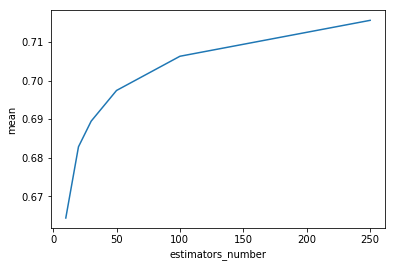

In [10]:
plot_chart(nums, scores, 'estimators_number', 'mean')

In [11]:
max_score, best_num = max(zip(scores, nums))
print('Best num =', best_num)
print('Max Score =', max_score)

Best num = 250
Max Score = 0.715640710503


Как видно из графика, увеличение кол-ва деревьев в градиентном бустинге приводит к увеличению оценки качества. Вместе с этим увеличивается и время обучения. Чтобы снизить время обучения, можно исспользовать не всю выборку, а некоторое её подмножество. Также можно уменьшить глубину деревьев в градиентном бустинге.

### Подход 2: логистическая регрессия

In [12]:
def start_logistic_regression(x_in):
    powers = np.power(10.0, np.arange(-5, 6))
    means = []

    for c in powers:
        print('\nC =', c)

        clf = LogisticRegression(C=c, random_state=241, n_jobs=-1)

        start_time = datetime.datetime.now()
        score = cross_val_score(clf, x_in, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        finish_time = datetime.datetime.now() - start_time

        mean = np.mean(score)
        means.append(mean)

        print('score =', score)
        print('mean =', mean)
        print('time =', finish_time)

    return powers, means

In [13]:
scaler = StandardScaler()

In [14]:
scale_x = scaler.fit_transform(X)

In [15]:
c_parameters, scores = start_logistic_regression(scale_x)


C = 1e-05
score = [ 0.69959206  0.69159358  0.69419291  0.69433159  0.69589176]
mean = 0.695120379847
time = 0:00:03.565368

C = 0.0001
score = [ 0.7161759   0.7083769   0.70960313  0.71017245  0.71192219]
mean = 0.711250114392
time = 0:00:03.611249

C = 0.001
score = [ 0.72134945  0.71368677  0.71425051  0.71512064  0.71649386]
mean = 0.716180246368
time = 0:00:05.371855

C = 0.01
score = [ 0.7216634   0.71377395  0.71440813  0.71540233  0.7164595 ]
mean = 0.716341462187
time = 0:00:06.619706

C = 0.1
score = [ 0.72165841  0.7137031   0.71438941  0.71539496  0.71640454]
mean = 0.716310083653
time = 0:00:06.807676

C = 1.0
score = [ 0.72165762  0.71369565  0.71438656  0.71539329  0.7163998 ]
mean = 0.716306583646
time = 0:00:06.821774

C = 10.0
score = [ 0.72165702  0.7136947   0.71438623  0.71539423  0.71639952]
mean = 0.71630633996
time = 0:00:06.924554

C = 100.0
score = [ 0.72165734  0.71369455  0.7143859   0.71539408  0.71639946]
mean = 0.716306265779
time = 0:00:07.023105

C = 1

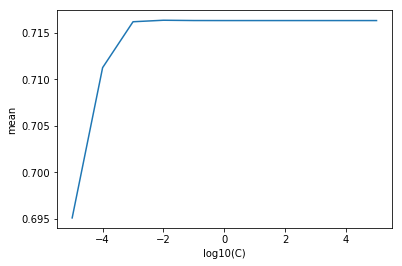

In [16]:
plot_chart(np.log10(c_parameters), scores, 'log10(C)', 'mean')

In [17]:
max_score, best_c = max(zip(scores, c_parameters))
print('Best C =', best_c)
print('Max Score =', max_score)

Best C = 0.01
Max Score = 0.716341462187


Наилучшего качества логистическая регрессия достигает при параметре регуляризации C = 0.01, при этом оценка качества составляет 0.716. Это значение больше, чем оценка качества градиентного бустинга с кол-вом деревьев 250, при этом логистическая регрессия обучается значительно быстрее.

### Удаление категориальных признаков

In [18]:
def remove_category_features(x_in):
    del_list = ['{}{}_hero'.format(name, val) for val in range(1, 6) for name in ['r', 'd']]
    del_list.append('lobby_type')
    x = x_in.drop(del_list, axis=1)
    return x

In [19]:
x_without_category = remove_category_features(X)
scale_x = scaler.fit_transform(x_without_category)

In [20]:
c_parameters, scores = start_logistic_regression(scale_x)


C = 1e-05
score = [ 0.69961316  0.69150564  0.69419646  0.69425458  0.69571482]
mean = 0.695056932991
time = 0:00:03.586067

C = 0.0001
score = [ 0.71630684  0.70828717  0.70971489  0.71020968  0.71172337]
mean = 0.711248390616
time = 0:00:04.345803

C = 0.001
score = [ 0.72152794  0.71360976  0.71445497  0.71521698  0.71636831]
mean = 0.716235591021
time = 0:00:05.387756

C = 0.01
score = [ 0.7218164   0.71370124  0.71462628  0.71551614  0.71634469]
mean = 0.716400950653
time = 0:00:06.624780

C = 0.1
score = [ 0.72181205  0.7136378   0.7146095   0.71551012  0.71629945]
mean = 0.716373784472
time = 0:00:07.219536

C = 1.0
score = [ 0.72181039  0.71363045  0.71460884  0.71551016  0.71629392]
mean = 0.716370752658
time = 0:00:06.362482

C = 10.0
score = [ 0.72181043  0.71362965  0.71460893  0.71551033  0.71629306]
mean = 0.716370479305
time = 0:00:07.039675

C = 100.0
score = [ 0.72181067  0.71362945  0.71460889  0.71551027  0.71629322]
mean = 0.716370496271
time = 0:00:06.388555

C = 

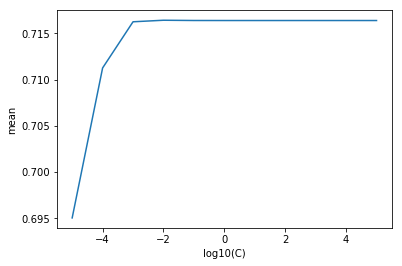

In [21]:
plot_chart(np.log10(c_parameters), scores, 'log10(C)', 'mean')

In [22]:
max_score, best_c = max(zip(scores, c_parameters))
print('Best C =', best_c)
print('Max Score =', max_score)

Best C = 0.01
Max Score = 0.716400950653


Удаление категориальных признаков никак не повлияло на изменение оценки качества классификации. Максимального значения в 0.716 оценка достигает также при параметре регуляризации C = 0.01.

### Вычисление кол-ва героев в игре

In [23]:
heroes = pandas.read_csv('samples/heroes.csv')
n_heroes = len(heroes)
print('Heroes number =', n_heroes)

Heroes number = 112


### Формирование мешка слов по героям

In [32]:
def get_bow_data(in_data):
    x_pick = np.zeros((in_data.shape[0], n_heroes))
    for i, match_id in enumerate(in_data.index):
        for p in range(5):
            x_pick[i, in_data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            x_pick[i, in_data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
    bow_data = pandas.DataFrame(x_pick, index=in_data.index)
    return bow_data

In [33]:
bow_train_data = get_bow_data(data)
final_x = pandas.concat([x_without_category, bow_train_data], axis=1)
scale_x = scaler.fit_transform(final_x)

In [35]:
c_parameters, scores = start_logistic_regression(scale_x)


C = 1e-05
score = [ 0.71907467  0.71117649  0.71512939  0.71288168  0.71586231]
mean = 0.71482490643
time = 0:00:03.804348

C = 0.0001
score = [ 0.74685672  0.74006714  0.74277168  0.74026225  0.74423779]
mean = 0.74283911658
time = 0:00:05.036173

C = 0.001
score = [ 0.75515333  0.74931124  0.75181648  0.74901026  0.75305284]
mean = 0.751668830891
time = 0:00:08.185122

C = 0.01
score = [ 0.75521596  0.74985583  0.75218088  0.74951097  0.75308879]
mean = 0.751970489032
time = 0:00:11.082162

C = 0.1
score = [ 0.75513027  0.74989157  0.75213472  0.74953537  0.75293117]
mean = 0.751924620917
time = 0:00:11.498718

C = 1.0
score = [ 0.75511969  0.74989604  0.75212742  0.74953884  0.75290574]
mean = 0.751917547936
time = 0:00:12.128124

C = 10.0
score = [ 0.75511883  0.74989652  0.75212657  0.74953969  0.75290278]
mean = 0.751916878023
time = 0:00:12.009859

C = 100.0
score = [ 0.75511879  0.74989678  0.75212649  0.74953983  0.75290249]
mean = 0.751916875841
time = 0:00:11.892691

C = 10

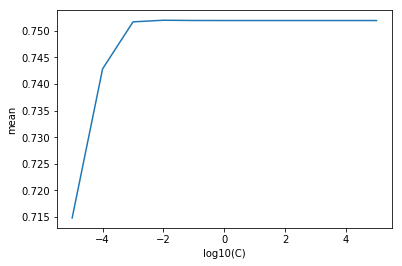

In [36]:
plot_chart(np.log10(c_parameters), scores, 'log10(C)', 'mean')

In [37]:
max_score, best_c = max(zip(scores, c_parameters))
print('Best C =', best_c)
print('Max Score =', max_score)

Best C = 0.01
Max Score = 0.751970489032


При добавлении мешка слов по героям значение оценки качесва классификации заметно улучшилось. Это связано с тем, что теперь мы используем категориальные признаки более разумно, т. к. герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Наилучшего качества логистическая регрессия с мешком слов по героям достигает при параметре регуляризации C = 0.01, при этом оценка качества составляет 0.752.

### Подготовка тестовых данных

In [38]:
x_test = pandas.read_csv('samples/features_test.csv', index_col='match_id')
x_test = x_test.fillna(0)
bow_test_data = get_bow_data(x_test)
x_test_without_category = remove_category_features(x_test)
final_x_test = pandas.concat([x_test_without_category, bow_test_data], axis=1)
scale_x_test = scaler.fit_transform(final_x_test)

### Проверка модели на тестовых данных

In [39]:
model = LogisticRegression(C=best_c, random_state=241, n_jobs=-1)
model.fit(scale_x, y)
y_test = model.predict_proba(scale_x_test)
p = list(map(lambda v: max(v), y_test))
max_p = max(p)
min_p = min(p)
print('max p =', max_p)
print('min p =', min_p)

max p = 0.996328715925
min p = 0.500007848132


Минимальное значение прогноза: 0.500

Максимальное значение прогноза: 0.996